In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force TensorFlow to use CPU
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

## 1. Data Set Loading

In [5]:
# -----------------------------
# 1. Dataset Setup
# -----------------------------
data_dir = "datasetn" # dataset/halt, dataset/freeze, dataset/pistol

img_size = (224, 224)
batch_size = 32

In [4]:
import os
print("Files in datasetn:", os.listdir(data_dir))


Files in datasetn: ['freeze', 'halt', 'pistol']


## 2. Data Set Splitting & Augmentation

In [ ]:
# Use validation_split to automatically split data
datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0,1] for faster convergence
    validation_split=0.2,        # Reserve 20% of data for validation
    rotation_range=20,           # Randomly rotate images within 20 degrees
    width_shift_range=0.2,       # Randomly shift images horizontally by up to 20% of width
    height_shift_range=0.2,      # Randomly shift images vertically by up to 20% of height
    shear_range=0.2,             # Apply random shearing transformations (slanting the image)
    zoom_range=0.2,              # Randomly zoom in/out up to 20%
    horizontal_flip=True,        # Randomly flip images horizontally (mirror effect)
    fill_mode="nearest",         # Fill empty pixels after rotation/shift using nearest pixel values
    brightness_range=(0.7, 1.3), # Randomly adjust brightness between 70% (darker) and 130% (brighter)
    channel_shift_range=30.0     # Randomly shift color channels to simulate lighting/color variations
)


train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",
    subset="training"
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size= 16,            # batchsize=16 used for validation to reduce memory usage during evaluation
    shuffle=False,             # Don't shuffle validation data to maintain order for evaluation
    class_mode="categorical",
    subset="validation"
)




Found 960 images belonging to 3 classes.
Found 237 images belonging to 3 classes.


In [6]:
# Check distributions
train_classes, train_counts = np.unique(train_generator.classes, return_counts=True)
val_classes, val_counts = np.unique(val_generator.classes, return_counts=True)

print("Training set distribution:")
for cls, count in zip(train_classes, train_counts):
    print(f"{cls}: {count} images")

print("\nValidation set distribution:")
for cls, count in zip(val_classes, val_counts):
    print(f"{cls}: {count} images")


Training set distribution:
0: 320 images
1: 320 images
2: 320 images

Validation set distribution:
0: 79 images
1: 79 images
2: 79 images


## 3. Model Development

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization

In [ ]:
# -----------------------------
# 2. Model Setup (MobileNetV2)
# -----------------------------
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense( 128, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)   # Batch Normalization
x = Dropout(0.5)(x)
predictions = Dense(3, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)


print(train_generator.class_indices)
print(np.unique(train_generator.classes, return_counts=True))


{'freeze': 0, 'halt': 1, 'pistol': 2}
(array([0, 1, 2], dtype=int32), array([320, 320, 320]))


## 4. Model Training

### **Stage-1**

In [ ]:
#-----------------------------
#3. Compile & Train
#-----------------------------



model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])


checkpoint = ModelCheckpoint(
    filepath="/content/drive/MyDrive/Research-2/best_hand_signal_model.keras",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    verbose=1
)


history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 1,
    callbacks=[checkpoint]
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

import pickle

with open("history_stage1.pkl", "wb") as f:
    pickle.dump(history.history, f)

### Learning Curves – Stage 1

In [ ]:
#-----------------------------
#Learning Curves – Stage 1
#-----------------------------

import matplotlib.pyplot as plt

epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, history.history['loss'], label='Train Loss (Stage 1)')
plt.plot(epochs, history.history['val_loss'], label='Val Loss (Stage 1)')
plt.legend()
plt.title('Stage 1 Loss')

plt.subplot(1,2,2)
plt.plot(epochs, history.history['accuracy'], label='Train Acc (Stage 1)')
plt.plot(epochs, history.history['val_accuracy'], label='Val Acc (Stage 1)')
plt.legend()
plt.title('Stage 1 Accuracy')

plt.show()

 ## 5. Fine-Tuning MobileNetV2

In [ ]:
# -----------------------------
# 5. Fine-tuning MobileNetV2
# -----------------------------

# base_model = model.layers[0]   # MobileNetV2
base_model.trainable = True

# Freeze early layers, train deeper layers
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000005),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

checkpoint = ModelCheckpoint(
    filepath="/content/drive/MyDrive/Research-2/best_hand_signal_model.keras",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=60,
    callbacks=[checkpoint, early_stop]
)



import pickle

with open("history_finetune.pkl", "wb") as f:
    pickle.dump(history_finetune.history, f)

Epoch 1/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4556 - loss: 1.8111
Epoch 1: val_loss improved from inf to 1.94204, saving model to /content/drive/MyDrive/Research-2/best_hand_signal_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.4561 - loss: 1.8087 - val_accuracy: 0.3207 - val_loss: 1.9420
Epoch 2/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5262 - loss: 1.4278
Epoch 2: val_loss improved from 1.94204 to 1.88941, saving model to /content/drive/MyDrive/Research-2/best_hand_signal_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.5271 - loss: 1.4263 - val_accuracy: 0.3249 - val_loss: 1.8894
Epoch 3/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5994 - loss: 1.2667
Epoch 3: val_loss did not improve from 1.88941
30/30 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step - accuracy: 0.6006 - loss: 1.2648 - val_accuracy: 0.3207 - val_loss: 1.9559
Epoch 4/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6651 - loss: 1.1123
Epoch 4: val_los

### Learning Curves – Fine-Tuning

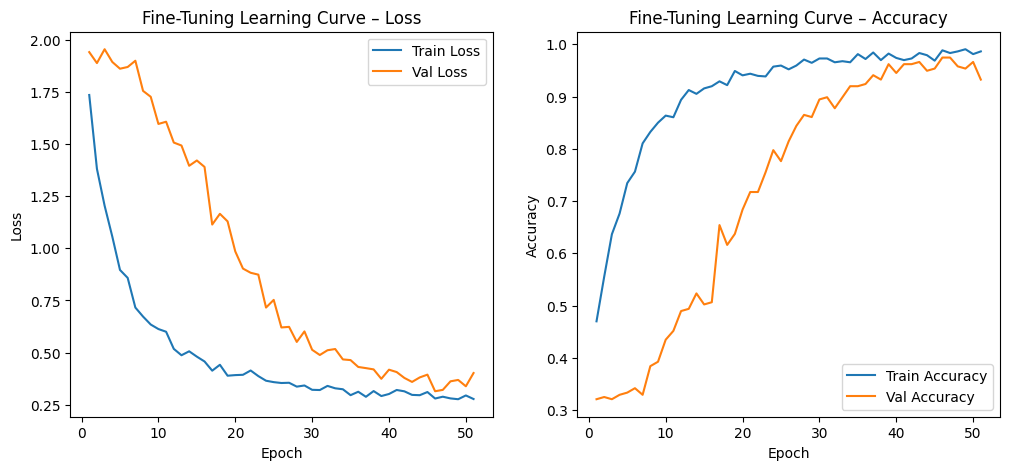

In [ ]:
# -----------------------------
# Learning Curves – Fine-Tuning
# -----------------------------

import matplotlib.pyplot as plt

epochs = range(1, len(history_finetune.history['loss']) + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, history_finetune.history['loss'], label='Train Loss')
plt.plot(epochs, history_finetune.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Fine-Tuning Learning Curve – Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history_finetune.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Fine-Tuning Learning Curve – Accuracy')
plt.legend()

plt.show()


##  **6. Testing Phrase**

### Test the model using one image

In [6]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Load trained model
model = tf.keras.models.load_model("best_hand_signal_model.keras")

# Class labels (must match your training generator)
class_names = ["halt", "freeze", "pistol"]

# Load and preprocess single image
img_path = "datasetn/pistol/IMG_7988.jpg"   # replace with your test image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # batch dimension

# Predict
pred = model.predict(img_array)
pred_class = class_names[np.argmax(pred)]

print("Predicted class:", pred_class)
print("Raw probabilities:", pred)





1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: pistol
Raw probabilities: [[6.0745860e-03 4.5565693e-04 9.9346972e-01]]


### Classification Report

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

tf.keras.backend.clear_session()

model = tf.keras.models.load_model("best_hand_signal_model.keras", compile=False)

val_generator.reset()

steps = int(np.ceil(val_generator.samples / val_generator.batch_size))

# CREATE LIST
y_pred_list = []

for _ in range(steps):
    x_batch, _ = next(val_generator)
    probs = model.predict(x_batch, verbose=0)
    y_pred_list.append(np.argmax(probs, axis=1))

# CONCATENATE ALL BATCH PREDICTIONS
y_pred = np.concatenate(y_pred_list)[:val_generator.samples]

y_true = val_generator.classes

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average='macro', zero_division=0))
print("Recall:", recall_score(y_true, y_pred, average='macro', zero_division=0))
print("F1-score:", f1_score(y_true, y_pred, average='macro', zero_division=0))
print(classification_report(
    y_true,
    y_pred,
    target_names=list(val_generator.class_indices.keys()),
    zero_division=0
))


Accuracy: 0.9493670886075949
Precision: 0.9527706000574218
Recall: 0.949367088607595
F1-score: 0.9493102162565249
              precision    recall  f1-score   support

      freeze       0.90      0.97      0.93        79
        halt       0.96      0.99      0.97        79
      pistol       1.00      0.89      0.94        79

    accuracy                           0.95       237
   macro avg       0.95      0.95      0.95       237
weighted avg       0.95      0.95      0.95       237



### Confusion Matrix

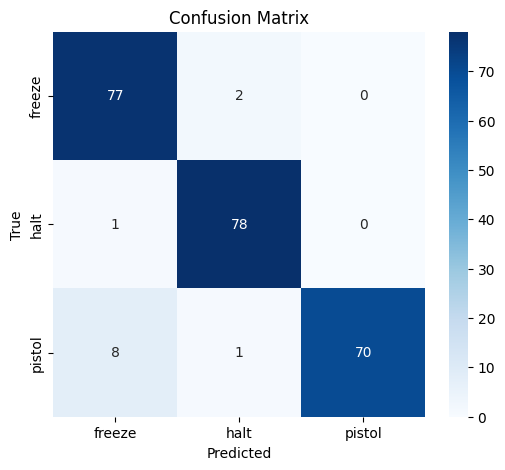

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_true, y_pred)
labels = list(val_generator.class_indices.keys())

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
